# Predicting Remaining Useful Life (advanced)
<p style="margin:30px">
    <img style="display:inline; margin-right:50px" width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
    <img style="display:inline" width=15% src="https://upload.wikimedia.org/wikipedia/commons/e/e5/NASA_logo.svg" alt="NASA" />
</p>

This notebook has a more advanced workflow than [the other notebook](Simple%20Featuretools%20RUL%20Demo.ipynb) for predicting Remaining Useful Life (RUL). If you are a new to either this dataset or Featuretools, I would recommend reading the other notebook first. 

## Highlights
* Demonstrate how novel entityset structures improve predictive accuracy
* Build custom primitives using time-series functions from [tsfresh](https://github.com/blue-yonder/tsfresh)
* Improve Mean Absolute Error by tuning hyper parameters with [BTB](https://github.com/HDI-Project/BTB)

Here is a collection of mean absolute errors from both notebooks. Though we've used averages where possible (denoted by \*), the randomness in the Random Forest Regressor and how we choose labels from the train data changes the score.

|                                 | Train/Validation MAE|  Test MAE|
|---------------------------------|--------------------------------|
| Median Baseline                 | 72.06*              | 50.66*   |
| Simple Featuretools             | 40.92*              | 39.56    |
| Advanced: Custom Primitives     | 35.90*              | 28.84    |
| Advanced: Hyperparameter Tuning | 34.80*              | 27.85    |


# Step 1: Load Data
We load in the train data using the same function we used in the previous notebook:

In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
import utils

data_path = 'data/train_FD004.txt'
data = utils.load_data(data_path)

data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


We also make cutoff times by selecting a random cutoff time from the life of each engine. We're going to make 5 sets of cutoff times to use for cross validation.

In [2]:
from tqdm import tqdm

splits = 5
cutoff_time_list = []

for i in tqdm(range(splits)):
    cutoff_time_list.append(utils.make_cutoff_times(data))

cutoff_time_list[0].head()

100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


,engine_no,cutoff_time,RUL
index,,,
1,1,2000-01-02 18:20:00,66
2,2,2000-01-04 19:30:00,70
3,3,2000-01-05 09:20:00,294
4,4,2000-01-08 22:40:00,56
5,5,2000-01-10 15:00:00,7


We're going to do something fancy for our entityset. The values for `operational_setting` 1-3 are continuous but create an implicit relation between different engines. If two engines have a similar `operational_setting`, it could indicate that we should expect the sensor measurements to mean similar things. We make clusters of those settings using [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from scikit-learn and make a new entity from the clusters.

In [3]:
from sklearn.cluster import KMeans

nclusters = 50

def make_entityset(data, nclusters, kmeans=None):
    X = data[['operational_setting_1', 'operational_setting_2', 'operational_setting_3']]
    if kmeans:
        kmeans=kmeans
    else:
        kmeans = KMeans(n_clusters=nclusters).fit(X)
    data['settings_clusters'] = kmeans.predict(X)
    
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=data,
                             entity_id='recordings',
                             index='index',
                             time_index='time')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='engines',
                        index='engine_no')
    
    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='settings_clusters',
                        index='settings_clusters')
    
    return es, kmeans
es, kmeans = make_entityset(data, nclusters)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 29]
    engines [Rows: 249, Columns: 2]
    settings_clusters [Rows: 50, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.settings_clusters -> settings_clusters.settings_clusters

## Visualize EntitySet

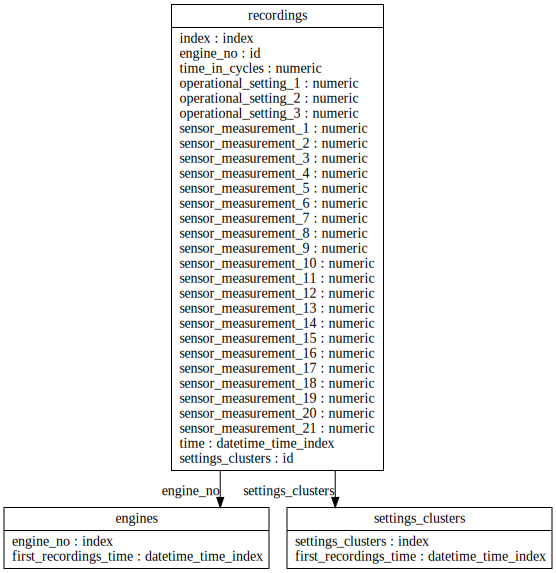

In [4]:
es.plot()

# Step 2: DFS and Creating a Model
In addition to changing our `EntitySet` structure, we're also going to use the [Complexity](http://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.cid_ce) time series primitive from the package [tsfresh](https://github.com/blue-yonder/tsfresh). Any function that takes in a pandas `Series` and outputs a float can be converted into an aggregation primitive using the `make_agg_primitive` function as shown below.

In [5]:
from featuretools.primitives import make_agg_primitive
import featuretools.variable_types as vtypes

from tsfresh.feature_extraction.feature_calculators import (number_peaks, mean_abs_change, 
                                                            cid_ce, last_location_of_maximum, length)


Complexity = make_agg_primitive(lambda x: cid_ce(x, False),
                              input_types=[vtypes.Numeric],
                              return_type=vtypes.Numeric,
                              name="complexity")

fm, features = ft.dfs(entityset=es, 
                      target_entity='engines',
                      agg_primitives=['last', 'max', Complexity],
                      trans_primitives=[],
                      chunk_size=.26,
                      cutoff_time=cutoff_time_list[0],
                      max_depth=3,
                      verbose=True)

fm.to_csv('advanced_fm.csv')
fm.head()

Built 302 features
Elapsed: 02:58 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 4/4 chunks


,LAST(recordings.time_in_cycles),LAST(recordings.operational_setting_1),LAST(recordings.operational_setting_2),LAST(recordings.operational_setting_3),LAST(recordings.sensor_measurement_1),LAST(recordings.sensor_measurement_2),LAST(recordings.sensor_measurement_3),LAST(recordings.sensor_measurement_4),LAST(recordings.sensor_measurement_5),LAST(recordings.sensor_measurement_6),...,COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_13)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_14)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_15)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_16)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_17)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_18)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_19)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_20)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_21)),RUL
engine_no,,,,,,,,,,,,,,,,,,,,,
1,255,35.0069,0.8400,100.0,449.44,555.72,1353.47,1123.29,5.48,7.97,...,5.189777,138.960656,0.725119,0.000000,36.031453,0,0.0,3.709334,2.289717,66
2,229,24.9997,0.6209,60.0,462.54,536.90,1264.76,1054.70,7.05,9.03,...,5.739238,359.581095,1.249528,0.069282,45.819376,0,0.0,4.022037,2.740721,70
3,13,10.0047,0.2512,100.0,489.05,604.45,1489.04,1305.94,10.52,15.48,...,1.931952,144.385849,0.310511,0.024495,12.887374,0,0.0,1.893923,1.144065,294
4,218,42.0043,0.8413,100.0,445.00,549.49,1362.89,1133.31,3.91,5.72,...,5.288050,391.499664,1.368005,0.135109,49.847261,0,0.0,5.690072,4.094572,56
5,186,42.0037,0.8416,100.0,445.00,549.76,1372.96,1146.10,3.91,5.72,...,8.086404,530.975717,1.233570,0.181146,48.756334,0,0.0,6.346465,4.327066,7


We build 4 more feature matrices with the same feature set but different cutoff times. That lets us test the pipeline multiple times before using it on test data.

In [6]:
fm_list = [fm]
for i in tqdm(range(1, splits)):
    fm = ft.calculate_feature_matrix(entityset=make_entityset(data, nclusters, kmeans=kmeans)[0], 
                                     features=features, 
                                     chunk_size=.26, 
                                     cutoff_time=cutoff_time_list[i])
    fm_list.append(fm)

100%|██████████| 4/4 [11:47<00:00, 177.18s/it]


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
def pipeline_for_test(fm_list, hyperparams={'n_estimators':100, 'max_feats':50, 'nfeats':50}, do_selection=False):
    scores = []
    regs = []
    selectors = []
    for fm in fm_list:
        X = fm.copy().fillna(0)
        y = X.pop('RUL')
        reg = RandomForestRegressor(n_estimators=int(hyperparams['n_estimators']), 
                                    max_features=min(int(hyperparams['max_feats']), 
                                                     int(hyperparams['nfeats'])))
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        if do_selection:
            reg2 = RandomForestRegressor(n_estimators=10, n_jobs=3)
            selector = RFE(reg2, int(hyperparams['nfeats']), step=25)
            selector.fit(X_train, y_train)
            X_train = selector.transform(X_train)
            X_test = selector.transform(X_test)
            selectors.append(selector)
        reg.fit(X_train, y_train)
        regs.append(reg)
        
        preds = reg.predict(X_test)
        scores.append(mean_absolute_error(preds, y_test))
    return scores, regs, selectors    
scores, regs, selectors = pipeline_for_test(fm_list)
print([float('{:.1f}'.format(score)) for score in scores])
print('Average MAE: {:.1f}, Std: {:.2f}\n'.format(np.mean(scores), np.std(scores)))

most_imp_feats = utils.feature_importances(fm_list[0], regs[0])

[40.2, 39.7, 35.2, 44.5, 40.8]
Average MAE: 40.1, Std: 2.98

1: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_13)) [0.105]
2: MAX(recordings.sensor_measurement_11) [0.074]
3: MAX(recordings.sensor_measurement_13) [0.067]
4: MAX(recordings.sensor_measurement_4) [0.047]
5: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_11)) [0.045]
-----



In [8]:
data_test = utils.load_data('data/test_FD004.txt')

es_test, _ = make_entityset(data_test, nclusters, kmeans=kmeans)
fm_test = ft.calculate_feature_matrix(entityset=es_test, features=features, verbose=True, chunk_size='cutoff time')
X = fm_test.copy().fillna(0)
y = pd.read_csv('data/RUL_FD004.txt', sep=' ', header=-1, names=['RUL'], index_col=False)
preds = regs[0].predict(X)
print('Mean Abs Error: {:.2f}'.format(mean_absolute_error(preds, y)))

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks
Mean Abs Error: 28.59


# Step 3: Feature Selection and Scoring
Here, we'll use [Recursive Feature Elimination](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). In order to set ourselves up for later optimization, we're going to write a generic `pipeline` function which takes in a set of hyperparameters and returns a score. Our pipeline will first run `RFE` and then split the remaining data for scoring by a `RandomForestRegressor`. We're going to pass in a list of hyperparameters, which we will tune later. 

Lastly, we can use that selector and regressor to score the test values.

# Step 4: Hyperparameter Tuning
Because of the way we set up our pipeline, we can use a Gaussian Process to tune the hyperparameters. We will use [BTB](https://github.com/HDI-Project/BTB) from the [HDI Project](https://github.com/HDI-Project). This will search through the hyperparameters `n_estimators` and `max_feats` for RandomForest, and the number of features for RFE to find the hyperparameter set that has the best average score.

In [9]:
from btb import HyperParameter, ParamTypes
from btb.tuning import GP

def run_btb(fm_list, n=30):
    hyperparam_ranges = [
            ('n_estimators', HyperParameter(ParamTypes.INT, [10, 200])),
            ('max_feats', HyperParameter(ParamTypes.INT, [5, 50])),
            ('nfeats', HyperParameter(ParamTypes.INT, [10, 70])),
    ]
    tuner = GP(hyperparam_ranges)

    tested_parameters = np.zeros((n, len(hyperparam_ranges)), dtype=object)
    scores = []
    
    print('[n_est, max_feats, nfeats]')
    best = 45

    for i in tqdm(range(n)):
        hyperparams = tuner.propose()
        cvscores, regs, selectors = pipeline_for_test(fm_list, hyperparams=hyperparams, do_selection=True)
        bound = np.mean(cvscores)
        tested_parameters[i, :] = hyperparams
        tuner.add(hyperparams, -np.mean(cvscores))
        if np.mean(cvscores) + np.std(cvscores) < best:
            best = np.mean(cvscores)
            best_hyperparams = hyperparams
            best_reg = regs[0]
            best_sel = selectors[0]
            print('{}. {} -- Average MAE: {:.1f}, Std: {:.2f}'.format(i, 
                                                                      best_hyperparams, 
                                                                      np.mean(cvscores), 
                                                                      np.std(cvscores)))
            print('Raw: {}'.format([float('{:.1f}'.format(s)) for s in cvscores]))

    return best_hyperparams, (best_sel, best_reg)

best_hyperparams, best_pipeline = run_btb(fm_list, n=30)


  0%|          | 0/30 [00:00<?, ?it/s]

[n_est, max_feats, nfeats]


  3%|▎         | 1/30 [00:13<06:45, 13.99s/it]

0. {'n_estimators': 80, 'max_feats': 20, 'nfeats': 40} -- Average MAE: 37.1, Std: 2.28
Raw: [40.0, 38.0, 34.1, 34.8, 38.5]


 33%|███▎      | 10/30 [02:23<04:40, 14.02s/it]

9. {'n_estimators': 80, 'max_feats': 21, 'nfeats': 41} -- Average MAE: 32.9, Std: 4.15
Raw: [34.4, 38.5, 26.3, 30.5, 34.7]


100%|██████████| 30/30 [07:09<00:00, 14.59s/it]


In [10]:
X = fm_test.copy().fillna(0)
y = pd.read_csv('data/RUL_FD004.txt', sep=' ', header=-1, names=['RUL'], index_col=False)

preds = best_pipeline[1].predict(best_pipeline[0].transform(X))
score = mean_absolute_error(preds, y)
print('Mean Abs Error on Test: {:.2f}'.format(score))
most_imp_feats = utils.feature_importances(X.iloc[:, best_pipeline[0].support_], best_pipeline[1])

Mean Abs Error on Test: 29.48
1: MAX(recordings.sensor_measurement_13) [0.139]
2: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_13)) [0.104]
3: MAX(recordings.sensor_measurement_11) [0.084]
4: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_11)) [0.083]
5: COMPLEXITY(recordings.settings_clusters.LAST(recordings.sensor_measurement_8)) [0.071]
-----



# Appendix: Averaging old scores
To make a fair comparison between the previous notebook and this one, we should average scores where possible. The work in this section is exactly the work in the previous notebook plus some code for taking the average in the validation step.

In [11]:
from featuretools.primitives import Min
old_fm, features = ft.dfs(entityset=es, 
                      target_entity='engines',
                      agg_primitives=['last', 'max', 'min'],
                      trans_primitives=[],
                      cutoff_time=cutoff_time_list[0],
                      max_depth=3,
                      verbose=True)

old_fm_list = [old_fm]
for i in tqdm(range(1, splits)):
    old_fm = ft.calculate_feature_matrix(entityset=make_entityset(data, nclusters, kmeans=kmeans)[0], 
                                     features=features, 
                                     cutoff_time=cutoff_time_list[i])
    old_fm_list.append(fm)

old_scores = []
median_scores = []
for fm in old_fm_list:
    X = fm.copy().fillna(0)
    y = X.pop('RUL')
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    reg = RandomForestRegressor(n_estimators=10)
    reg.fit(X_train, y_train)
    preds = reg.predict(X_test)
    old_scores.append(mean_absolute_error(preds, y_test))
    
    medianpredict = [np.median(y_train) for _ in y_test]
    median_scores.append(mean_absolute_error(medianpredict, y_test))

print([float('{:.1f}'.format(score)) for score in old_scores])
print('Average MAE: {:.2f}, Std: {:.2f}\n'.format(np.mean(old_scores), np.std(old_scores)))

print([float('{:.1f}'.format(score)) for score in median_scores])
print('Baseline by Median MAE: {:.2f}, Std: {:.2f}\n'.format(np.mean(median_scores), np.std(median_scores)))

Built 302 features
Elapsed: 03:16 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [13:36<00:00, 205.04s/it]


[30.0, 41.2, 43.3, 34.9, 37.4]
Average MAE: 37.35, Std: 4.72

[67.4, 64.3, 63.4, 65.1, 61.0]
Baseline by Median MAE: 64.23, Std: 2.10



In [12]:
y = pd.read_csv('data/RUL_FD004.txt', sep=' ', header=-1, names=['RUL'], index_col=False)
median_scores_2 = []
for ct in cutoff_time_list:
    medianpredict2 = [np.median(ct['RUL'].values) for _ in y.values]
    median_scores_2.append(mean_absolute_error(medianpredict2, y))
print([float('{:.1f}'.format(score)) for score in median_scores_2])
print('Baseline by Median MAE: {:.2f}, Std: {:.2f}\n'.format(np.mean(median_scores_2), np.std(median_scores_2)))

[49.5, 52.8, 49.0, 49.5, 48.3]
Baseline by Median MAE: 49.82, Std: 1.58



In [13]:
# Save output files

import os

try:
    os.mkdir("output")
except:
    pass

fm.to_csv('output/advanced_train_feature_matrix.csv')
cutoff_time_list[0].to_csv('output/advanced_train_label_times.csv')
fm_test.to_csv('output/advanced_test_feature_matrix.csv')

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact).